## Example 3 – One state variable
### Time-Varying Drift – Price Consumption Ratio
Here the setup is exactly the same as in example 1, but now I calculate the price consumption ratio instead of the price of zero coupon bond. By changing the values of the parameters it is also possible to compute a more general price-dividend ratio, for an asset that does not have the same dividend process as consumption. The modified process in this case is:

$$
\mathrm{d}\tilde{x}_t=\big(-\log\phi(\bar{x}-\tilde{x}_t) +\rho_{cx}\sigma_c\sigma_x+\rho_{xD}\sigma_x\sigma_D\big)\mathrm{d}t+\sigma_{x}\mathrm{d}W_{xt}
$$

In order to get the price of the zero-coupon security a process for the integral of the short-term rate will also be needed:

$$
\mathrm{d}\mathcal{I} = \tilde{r}(\tilde{x}_t)\mathrm{d}t
$$

##### Import the packages

In [1]:
import SDFPricing as sdf
import StochasticDiffEq as sde # this is needed in order to specify the algorithm

#### Define the parameters

In [2]:
cs = (
    phi = 0.92, # steady state reversion
    xbar = 0.0, # steady state
    rho = 0.02, # time preference parameter
    gamma = 2, # risk aversion
    muc0 = 0.01, # steady state consumption drift
    sigmac = 0.01, # consumption diffusion
    sigmax = 0.005, # state variable diffusion
    rhocx = 0.3, # correlation between consumption and state variable
    # sigmaD = 0.02, # dividend diffusion ###- added compared to example 1
    # muD = 0.02, # dividend drift ###- added compared to example 1
    # rhoxD = 0.5, # correlation between dividends and state variable ###- added compared to example 1
    # rhocD = 0.4 # correlation between dividends and consumption ###- added compared to example 1
    sigmaD = 0.01, # dividend diffusion ###- case of consumption perpetuity
    muD = 0.01, # dividend drift ###- case of consumption perpetuity
    rhoxD = 0.3, # correlation between dividends and state variable ###- case of consumption perpetuity
    rhocD = 1.0 # correlation between dividends and consumption ###- case of consumption perpetuity
);

#### Drift and Diffusion of the processes
I also include the unmodified process which will correspond to "risk-neutral pricing". By comparing normal pricing with risk-neutral pricing it is possible to compute excess returns.

In [3]:
# diffusion of modified state
sigma(x,c) = c.sigmax; 
# drift of modified state
mu(x,c) = -log(c.phi)*(c.xbar-x)-c.rhocx*c.gamma*c.sigmac*sigma(x,c)+c.rhoxD*sigma(x,c)*c.sigmaD 

mu (generic function with 1 method)

#### Short-term rate function

In [4]:
r(x,c) = c.rho+c.gamma*(c.muc0+x)-c.gamma^2*c.sigmac^2/2;
r(x) = r(x,cs);
muD(x) = cs.muD+x; #- case of consumption perpetuity
# muD(x) = cs.muD; #- perpetuity with constant dividend drift
rmod(x,c) = r(x,c)-(muD(x)-c.gamma*c.rhocD*c.sigmac*c.sigmaD);
rmod(x) = rmod(x,cs);

#### Define setup consistent with SDE solution in Julia

In [5]:
function drift(du,u,p,t,c)
    du[1] = mu(u[1],c)
    du[2] = rmod(u[1],c)
end
drift(du,u,p,t) = drift(du,u,p,t,cs);
function diffusion(du,u,p,t,c)
    du[1] = sigma(u[1],c)
    du[2] = 0.0
end
diffusion(du,u,p,t) = diffusion(du,u,p,t,cs);

#### Define the Problem and SolutionSettings variables

In the theory I state that the price consumption ratio is computed from the integral over all consumption strip maturities. In practice it is not possible to integrate to infinity. So, I compute consumption strips up to a maturity of 300 years.

In [6]:
prob = sdf.Problem(drift=drift,diffusion=diffusion,numNoiseVariables=1,outVariables=[2],
terminalFunction=(ik, x, y, z) -> exp(-x));
xRange = -0.05:0.006:0.05;
tRange = 0.0:5.0:300.0;
sett = sdf.SolutionSettings(xRanges=[xRange,], initialValues=[[x, 0.0] for x in xRange], 
algorithm=sde.LambaEM(), pathsPerInitialValue=5000, tRange=tRange);
# add the settings in order to compmute price-dividend ration of the continuous payoff security
sett2 = sdf.SolutionSettings(sett; continuousPayoffVars=[2]);

#### Solve Problem, Get Yield and Price Consumption Ratio

In [7]:
((consumptionStrip,),(priceConsumptionRatio,)) = sdf.solve(prob, sett2);

#### Get the Return of the Consumption Perpetuity
The calculation requires the computation of the first and second derivatives of the price consumption ratio with respect to the state of the economy.

In [8]:
(DPC,D2PC) = sdf.derivatives(priceConsumptionRatio);
ret(x) = (DPC(x)*(mu(x, cs) + sigma(x, cs) * cs.sigmac * cs.rhocx) + 
    D2PC(x)* sigma(x, cs)^2/2.0 + 1.0)/priceConsumptionRatio(x) + muD(x);

#### Plot the Consumption Strip Term Structure

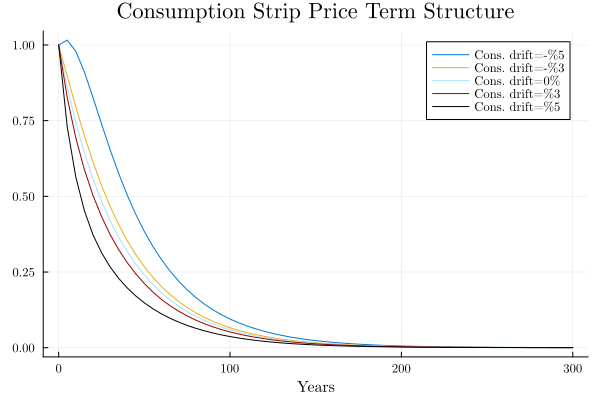

In [9]:
import Plots as plt
# # colors: "#0075d6", "#edad14", "#a3e3ff", "#9c0000", "#000000"
plt.default(titlefont= (14,"Computer Modern"),legendfont=(8,"Computer Modern"),
    tickfont=(8,"Computer Modern"),guidefont=(10,"Computer Modern"))
plt.plot(tRange, consumptionStrip.(tRange, -0.04),color="#0075d6", 
    title="Consumption Strip Price Term Structure", xlabel="Years",label="Cons. drift=-%5")
plt.plot!(tRange, consumptionStrip.(tRange, -0.01),label="Cons. drift=-%3",color="#edad14")
plt.plot!(tRange, consumptionStrip.(tRange, 0.0),label="Cons. drift=0%",color="#a3e3ff")
plt.plot!(tRange, consumptionStrip.(tRange, 0.01),label="Cons. drift=%3",color="#9c0000")
plt.plot!(tRange, consumptionStrip.(tRange, 0.04),label="Cons. drift=%5",color="#000000")


It can be seen that for all values of the state variable the price of the securities comes close to 0 for maturities as long as 300 years.

#### Plot the Price Consumption Ratio

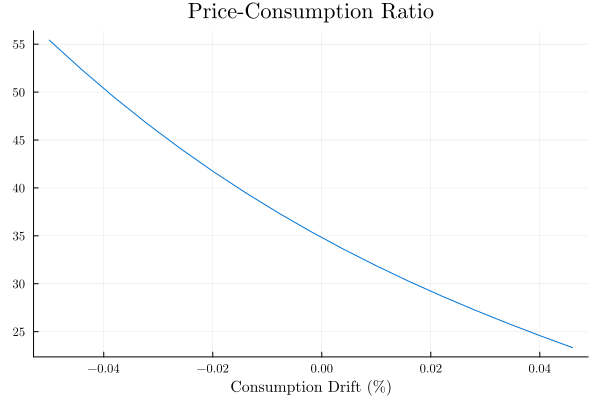

In [10]:
plt.plot(xRange, priceConsumptionRatio(xRange), legend=false,
    title="Price-Consumption Ratio",color="#0075d6", xlabel="Consumption Drift (%)")

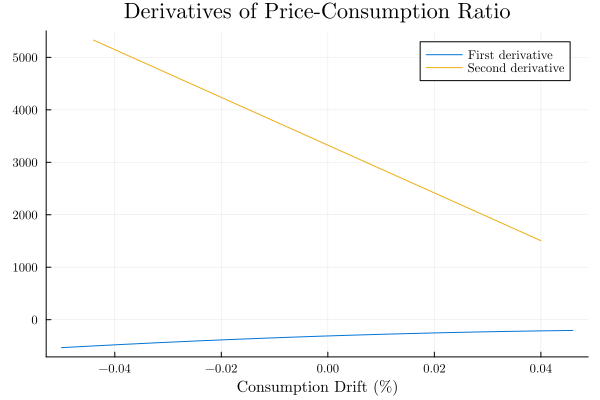

In [11]:
plt.plot(xRange, DPC.(xRange),
    title="Derivatives of Price-Consumption Ratio",label="First derivative",color="#0075d6")
plt.plot!(xRange[2:end-1], D2PC.(xRange[2:end-1]),label="Second derivative",color="#edad14",xlabel="Consumption Drift (%)")

#### Plot the Return

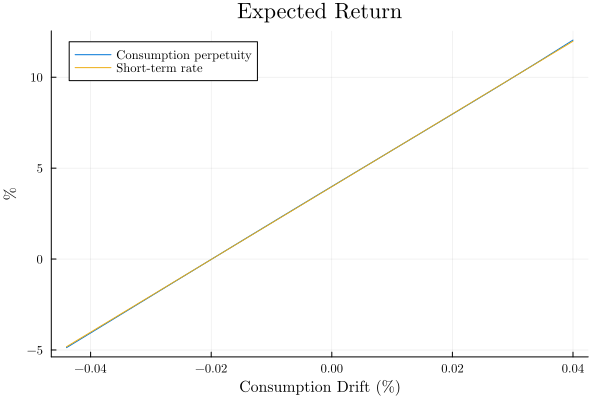

In [12]:
plt.plot(xRange[2:end-1], 100*ret.(xRange[2:end-1]), label="Consumption perpetuity",
    title="Expected Return", color="#0075d6",xlabel="Consumption Drift (%)",ylabel="%")
plt.plot!(xRange[2:end-1], 100*r.(xRange[2:end-1]),
    label="Short-term rate",color="#edad14")

As expected in the standard model with time-varying consumption drift the premium compared to the short-term rate is almost zero.